In [1]:
import os
import sys
import shutil
os.environ['TOKENIZERS_PARALLELISM'] = "False"

import torch
import pandas as pd
import numpy as np
import decord
import json
from IPython.display import display, Markdown, Latex
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
import PIL.Image
from glob import glob
from natsort import natsorted

from torch.utils.data import Dataset, DataLoader
from easydict import EasyDict as edict
import numpy as np
import json
import einops
from collections import defaultdict

import shared.utils as su
from utils.video import read_frames_decord
from utils.model import transform_pixel_values
from torchvision.transforms.v2 import (
    ToPILImage,
)
from models.modeling_encoders import AutoEncoder
from notebooks.eval_care_retrieval import load_model, load_data
from utils.video import read_frames_decord
from utils.model import transform_pixel_values
from torchvision.transforms.v2 import (
    ToPILImage,
    functional,
)

### Load model

In [2]:
model_paths = {
    # "Tarsier (Base Model)": "/work/piyush/pretrained_checkpoints/Tarsier-7b",
    # "TARA (Ours)": "/work/piyush/pretrained_checkpoints/TARA",
    "TARA (CoVR+CiA)": "/work/piyush/experiments/CaRe/Tarsier-7b/covr/chiral10k-covr10k/merged_checkpoint",
}
device_map = "auto"
attn_implementation = 'flash_attention_2'

models = {}
for key, model_path in model_paths.items():
    model = AutoEncoder.from_pretrained(
        model_path,
        device_map=device_map,
        attn_implementation=attn_implementation,
        use_flash_attn=False,
        dtype=torch.bfloat16,
    )
    models[key] = model
    su.misc.num_params(model.model)
    print("-" * 100)
len(models)

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Loading EncoderForTarsier from /work/piyush/experiments/CaRe/Tarsier-7b/covr/chiral10k-covr10k/merged_checkpoint
### do_image_padding is set as False, images will be resized directly!


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
TarsierForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
You are attempting to use Flash Attention 2.

use_flash_attn is True and Flash Attention 2 is available on this GPU.
Using attn_implementation for TarsierForConditionalGeneration: flash_attention_2


The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

::: Number of total parameters in TarsierForConditionalGeneration: 7063.427M
----------------------------------------------------------------------------------------------------


1

### Load data

In [3]:
from datasets import load_dataset
data = load_dataset("/scratch/shared/beegfs/piyush/datasets/MMEB-eval", 'CIRR')['test']
len(data)

1000

Show three bottles of soft drink.

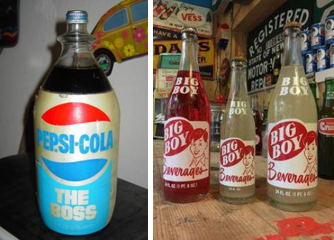

In [4]:
image_dir = "/scratch/shared/beegfs/piyush/datasets/MMEB-V2/image-tasks/MMEB/"
for d in data:
    caption = d['qry_text'].split(": ")[-1].strip("\n")

    query_image_path = f"{image_dir}/{d['qry_img_path']}"
    assert os.path.exists(query_image_path)
    query_image = PIL.Image.open(query_image_path)

    tgt_image_paths = [f"{image_dir}/{f}" for f in d['tgt_img_path']]

    display(Markdown(caption))
    display(
        su.visualize.concat_images_with_border(
            [
                su.visualize.resize_height(PIL.Image.open(query_image_path), 240),
                su.visualize.resize_height(PIL.Image.open(tgt_image_paths[0]), 240)
            ]
        )
    )
    break

### Inference

In [5]:
def read_image(image_path):
    image = PIL.Image.open(image_path)
    image = torch.tensor(np.asarray(image)).unsqueeze(0)
    image = image.permute((0, 3, 1, 2))
    return image


read_image('../../TimeBound.v1/sample_data/folding_paper.png').shape

pixel_values = read_frames_decord('../../TimeBound.v1/sample_data/folding_paper.mp4', 2)
pixel_values.shape

torch.Size([2, 3, 240, 426])

In [6]:
# PROMPT = "<image>\nEdit instruction: <sent>\n"\
#          "Imagine the given text edit instruction applied on the given image.\n"\
#          "Summarize the resulting image in one word:"

PROMPT = "Source image: <video>\nEdit instruction: <sent>\n"\
        "Look at the attached image carefully. The provided text is instruction to edit the image to a new sentence. "\
        "Imagine this edit instruction being applied to the provided image.\n"\
        "Summarize the resulting edited image in one word:"
PROMPT = f"USER: {PROMPT} ASSISTANT: "


def embed_image_text(encoder, image_path, edit_text, verbose=False):
    generate_kwargs = {
        "max_new_tokens": 1,
        "output_hidden_states": True,
        "return_dict_in_generate": True,
    }

    # Prepare image
    pixel_values = read_image(image_path)
    pixel_values = transform_pixel_values(pixel_values)
    # print(pixel_values.shape)
    nframes = pixel_values.shape[1]
    to_image = ToPILImage()
    batched_frames = []
    for batch in pixel_values:
        frames = [to_image(v) for v in batch]
        batched_frames.append(frames)

    for frames in batched_frames:

        # Video
        input_prompt = PROMPT.replace("<video>", "<image>"*len(frames))

        # Text
        input_prompt = input_prompt.replace('<sent>', edit_text)

        if verbose:
            print(input_prompt)

        input_ids = encoder.processor.get_text_inputs(input_prompt)
        frames = encoder.processor.get_pixel_values(frames)
        inputs = {
            "input_ids": input_ids,
            "pixel_values": frames
        }
        inputs = {k:v.to(encoder.model.device) for k,v in inputs.items() if v is not None}
        outputs = encoder.model.generate(
            **inputs,
            **generate_kwargs,
        )
        zv = outputs.hidden_states[0][-1][:, -1, :]
        break # Safe to break since it is just one video

    if verbose:
        print(zv.shape)

    return zv.squeeze(0)


image_path = '../../TimeBound.v1/sample_data/folding_paper.png'
zv = embed_image_text(model, image_path, "Change background to blue.", verbose=True)

Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.


USER: Source image: <image>
Edit instruction: Change background to blue.
Look at the attached image carefully. The provided text is instruction to edit the image to a new sentence. Imagine this edit instruction being applied to the provided image.
Summarize the resulting edited image in one word: ASSISTANT: 


Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


torch.Size([1, 4096])


**Compute embeddings for all targets**

In [7]:
tgt_paths = []
for d in su.log.tqdm_iterator(data):
    tgt_image_paths = [f"{image_dir}/{f}" for f in d['tgt_img_path']]
    tgt_paths.extend(tgt_image_paths)
tgt_paths = np.unique(tgt_paths)
len(tgt_paths)

  0%|          | 0/1000 [00:00<?, ?it/s]

2197

In [8]:
tgt_embeds = {}
for f in su.log.tqdm_iterator(tgt_paths, desc="Computing embeddings for target images"):
    with torch.no_grad():
        pixel_values = read_image(f)
        zv = model.encode_vision(pixel_values).squeeze(0).cpu().float()
    tgt_embeds[f] = zv
len(tgt_embeds)

Computing embeddings for target images:   0%|          | 0/2197 [00:00<?, ?it/s]

2197

**Compute query embeddings**

In [9]:
# recall_at_k = {1: [], 5: []}
correct = []

for d in su.log.tqdm_iterator(data):
    caption = d['qry_text'].split(": ")[-1].strip("\n")
    query_image_path = f"{image_dir}/{d['qry_img_path']}"
    with torch.no_grad():
        zq = embed_image_text(model, query_image_path, caption).cpu().float()
        zq = torch.nn.functional.normalize(zq, dim=-1)

    tgt_image_paths = [f"{image_dir}/{f}" for f in d['tgt_img_path']]
    zt = torch.stack([tgt_embeds[f] for f in tgt_image_paths])
    zt = torch.nn.functional.normalize(zt, dim=-1)

    sim = zq @ zt.T

    correct.append(torch.argmax(sim) == 0)
correct = torch.tensor(correct).float()

accuracy = torch.mean(correct)
print("Accuracy: ", accuracy)

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy:  tensor(0.3270)


* Base model: 0.1390
* TARA: 0.1570
* TARA (CiA+CoVR): 0.3270

## Old code

In [54]:
data_root = "/scratch/shared/beegfs/piyush/datasets/CoIR"

mode = "rc2.val"
split_path = f"{data_root}/cirr/image_splits/split.{mode}.json"
caps_path = f"{data_root}/cirr/captions/cap.{mode}.json"
assert os.path.exists(split_path)
assert os.path.exists(caps_path)

In [55]:
split = su.io.load_json(split_path)
len(split)

2297

In [56]:
caps = su.io.load_json(caps_path)
len(caps)

4181

In [120]:
image_dir = f"{data_root}/NLVR2-lmms/images/dev-all"

folders = natsorted(glob(f"{image_dir}/*"))

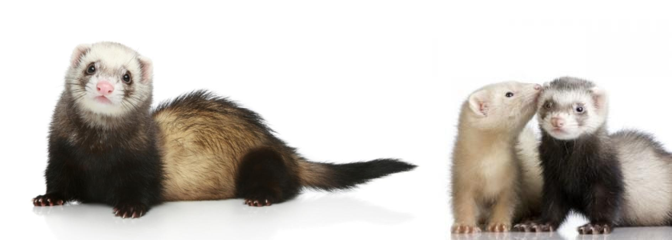

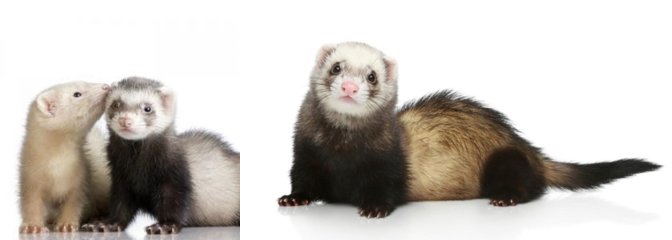

In [125]:
i = 4200
display(
    su.visualize.concat_images_with_border(
        [su.visualize.resize_height(PIL.Image.open(f), 240) for f in glob(f"{folders[i]}/*.jpg")]
    )
)
display(
    su.visualize.concat_images_with_border(
        [su.visualize.resize_height(PIL.Image.open(f), 240) for f in glob(f"{folders[i+1]}/*.jpg")]
    )
)

In [127]:
data = su.io.load_json(f"{data_root}/NLVR2-lmms/metadata_all.json")
len(data)

df = []
for k in data:
    _df = pd.DataFrame(data[k])
    _df['split'] = k
    df.append(_df)
df = pd.concat(df).reset_index(drop=True)
df.shape

(17506, 12)

In [130]:
def image_id_to_path(image_id):
    image_index = int(image_id[-1])
    image_suffix = "left" if image_index == 0 else "right"
    image_folder = image_id.replace("img", "")
    # image_folder = '-'.join(image_id.split("-")[:-1]) + '-1'
    path = f"{image_dir}/{image_folder}/{image_suffix}_image.jpg"
    # print(path)
    assert os.path.exists(path)
    return path

In [151]:
# i = np.random.randint(len(caps))
i = 2
x = caps[i]
print(json.dumps(x, indent=4))

ref_image_path = image_id_to_path(x['reference'])
ref_image = PIL.Image.open(ref_image_path)

tgt_image_path = image_id_to_path(x['target_hard'])
tgt_image = PIL.Image.open(tgt_image_path)

display(Markdown('---'))
display(Markdown(x['caption']))
display(
    su.visualize.concat_images_with_border(
        [su.visualize.resize_height(ref_image, 240), su.visualize.resize_height(tgt_image, 240)]
    )
)
display(Markdown('---'))

{
    "pairid": 12081,
    "reference": "dev-1042-0-img0",
    "target_hard": "dev-1044-1-img1",
    "target_soft": {
        "dev-1044-1-img1": 1.0
    },
    "caption": "Two animals that are of a different species from the first one, and no human appearing",
    "img_set": {
        "id": 48,
        "members": [
            "dev-998-1-img0",
            "dev-940-3-img0",
            "dev-1042-2-img1",
            "dev-1044-1-img1",
            "dev-1004-2-img0",
            "dev-1042-0-img0"
        ],
        "reference_rank": 0,
        "target_rank": 1
    }
}


AssertionError: 

In [146]:
verbose = False
failed = []
for i in su.log.tqdm_iterator(range(len(caps)), desc='Checking'):
    x = caps[i]
    if verbose:
        print(json.dumps(x, indent=4))

    try:
        ref_image_path = image_id_to_path(x['reference'])
        ref_image = PIL.Image.open(ref_image_path)
        
        tgt_image_path = image_id_to_path(x['target_hard'])
        tgt_image = PIL.Image.open(tgt_image_path)
    except:
        failed.append(i)
    
    if verbose:
        display(Markdown('---'))
        display(Markdown(x['caption']))
        display(
            su.visualize.concat_images_with_border(
                [su.visualize.resize_height(ref_image, 240), su.visualize.resize_height(tgt_image, 240)]
            )
        )
        display(Markdown('---'))
        break

print("Number of successful samples: ", len(caps) - len(failed))

Checking:   0%|          | 0/4181 [00:00<?, ?it/s]

Number of successful samples:  2269


In [148]:
len(failed), failed[:4]

(1912, [0, 2, 3, 4])

{'pairid': 12063,
 'reference': 'test1-147-1-img1',
 'caption': 'remove all but one dog and add a woman hugging it',
 'img_set': {'id': 1,
  'members': ['test1-147-1-img1',
   'test1-1001-2-img0',
   'test1-83-1-img1',
   'test1-359-0-img1',
   'test1-906-0-img1',
   'test1-83-0-img1'],
  'reference_rank': 3}}

In [47]:
def image_id_to_path(image_id):
    image_dir = f"{data_root}/NLVR2/images"

    # '-'.join(image_id.split("-")[:-1])

    image_index = image_id[-1]
    image_folder = image_id.replace("img", "")
    # image_folder = '-'.join(image_id.split("-")[:-1]) + '-1'
    path = f"{image_dir}/{image_folder}/image_{image_index}.jpg"
    assert os.path.exists(path)
    return path

In [48]:
x = caps[2]
image_reference = image_id_to_path(x['reference'])
image_members = []
for _id in x['img_set']['members']:
    image_members.append(image_id_to_path(_id))
len(image_members)

6

In [49]:
x

{'pairid': 12065,
 'reference': 'test1-83-1-img1',
 'caption': 'shows two dogs eating',
 'img_set': {'id': 1,
  'members': ['test1-147-1-img1',
   'test1-1001-2-img0',
   'test1-83-1-img1',
   'test1-359-0-img1',
   'test1-906-0-img1',
   'test1-83-0-img1'],
  'reference_rank': 5}}

In [50]:
image_members

['/scratch/shared/beegfs/piyush/datasets/CoIR/NLVR2/images/test1-147-1-1/image_1.jpg',
 '/scratch/shared/beegfs/piyush/datasets/CoIR/NLVR2/images/test1-1001-2-0/image_0.jpg',
 '/scratch/shared/beegfs/piyush/datasets/CoIR/NLVR2/images/test1-83-1-1/image_1.jpg',
 '/scratch/shared/beegfs/piyush/datasets/CoIR/NLVR2/images/test1-359-0-1/image_1.jpg',
 '/scratch/shared/beegfs/piyush/datasets/CoIR/NLVR2/images/test1-906-0-1/image_1.jpg',
 '/scratch/shared/beegfs/piyush/datasets/CoIR/NLVR2/images/test1-83-0-1/image_1.jpg']

shows two dogs eating

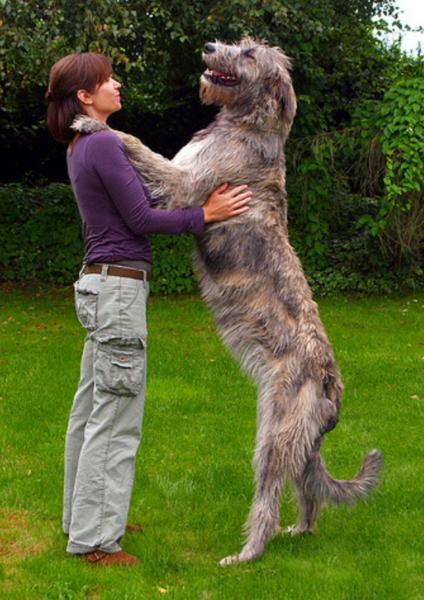

In [51]:
display(Markdown(x['caption']))
PIL.Image.open(image_reference)

In [52]:
image_members

['/scratch/shared/beegfs/piyush/datasets/CoIR/NLVR2/images/test1-147-1-1/image_1.jpg',
 '/scratch/shared/beegfs/piyush/datasets/CoIR/NLVR2/images/test1-1001-2-0/image_0.jpg',
 '/scratch/shared/beegfs/piyush/datasets/CoIR/NLVR2/images/test1-83-1-1/image_1.jpg',
 '/scratch/shared/beegfs/piyush/datasets/CoIR/NLVR2/images/test1-359-0-1/image_1.jpg',
 '/scratch/shared/beegfs/piyush/datasets/CoIR/NLVR2/images/test1-906-0-1/image_1.jpg',
 '/scratch/shared/beegfs/piyush/datasets/CoIR/NLVR2/images/test1-83-0-1/image_1.jpg']

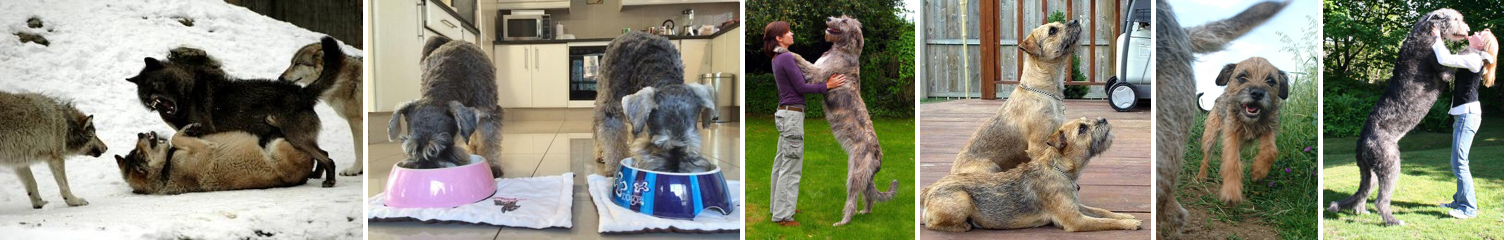

In [53]:
su.visualize.concat_images_with_border(
    [su.visualize.resize_height(PIL.Image.open(f), 240) for f in image_members]
)

In [17]:
split[caps[0]['reference']]

'./dev/dev-244-0-img0.png'

In [8]:
split['test1-147-1-img1']

'./test1/test1-147-1-img1.png'